Declaring some variables and pacakges

In [79]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, bernoulli
import scipy.optimize as optimize
import math
from prettytable import PrettyTable

N = 10
magnitude = 1.2
mu = 0  # loc
sigma = 1  # beta
alpha = 0
gamma = 0.1
x = np.linspace(-1, 1, N)
params = [1, -8, 4, 3, 5]
model_order = np.linspace(0,9,10)

Function for creating the true model and functino for adding noise

In [80]:
def create_y_model(params):
    def y(x): return sum([p*(x**i) for i, p in enumerate(params)])
    return y

def add_noise_to_true_model(x,N, params, magnitude, alpha, mu, sigma):
    y = create_y_model(params)
    y_true = y(x)
    y_added_noise = y_true + magnitude * \
        (alpha*np.random.normal(mu, sigma, N) +
         (1-alpha)*np.random.laplace(mu, sigma, N))
    return y_added_noise

Creating our measurment data and plotting it

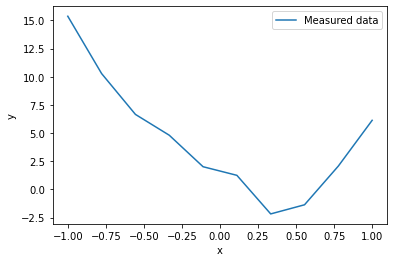

In [81]:
y_measured_data = add_noise_to_true_model(x,N, params, magnitude, alpha, mu, sigma)
plt.figure()
plt.plot(x, y_measured_data, label="Measured data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Splitting up the data into training and testing set

In [82]:
y_traning_set = y_measured_data[0:math.floor(len(y_measured_data)*1/2)]
x_traning_set = x[0:math.floor(len(x)/2)]
y_testing_set = y_measured_data[math.floor(len(y_measured_data)*1/2):]
x_testing_set = x[math.floor(len(x)*1/2):]


Function for estimating the LS parameters for each mode

In [83]:
def LS_estimator_given_mode(mode, x, y):
    u_tensor_0 = np.reshape(x, (len(x), 1))

    
    ones_vec = np.ones((len(x), 1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    if mode ==1:
        u_tensor = ones_vec
    for i in range(2, mode):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i), axis=1)

    u_transpose_dot_u = np.dot(u_tensor.T, u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(
        u_transpose_dot_u)  # calculating inverse
    u_transpose_dot_y = np.dot(u_tensor.T, y)  # calculating dot product

    LS_params = np.dot(u_transpose_dot_u_inv, u_transpose_dot_y)
    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    return LS_params

Function for estimating ML parameters for each mode

In [84]:
def log_lik(par_vec,x,y):
    pdf = laplace.pdf
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc=sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale=par_vec[-1])

    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))


def ML_estimator_given_mode(mode,x,y):
    init_guess = np.zeros(mode+1)
    init_guess[-1] = len(x)

    opt_res = optimize.minimize(fun=log_lik,
                                x0=init_guess,
                                options={'disp': False},
                                args=(x,y))
    MLE_params = opt_res.x[:-1]
    MLE_params = MLE_params.tolist()
    return MLE_params


Creating a function wich takes in data, model orders as a vector and the type of model (LS or ML) as an argument.
Function return the models with the estimated parameters based on the given data

In [85]:
def creating_different_model(x_data, y_data,data,type):
    if type == "ML":
        for i in range(len(data)):
            data[i] = ML_estimator_given_mode(i + 1,x_data,y_data)
            data[i]= create_y_model(data[i])
    if type == "LS":
        for i in range(len(data)):
            data[i] = LS_estimator_given_mode(i + 1,x_data,y_data)
            data[i]= create_y_model(data[i])

    return data


Declaring and estimating the parameters for the 10 LS and ML models

In [86]:
y_hat_ML_10_models = [0] *10
y_hat_LS_10_models = [0] *10

creating_different_model(x, y_measured_data,y_hat_LS_10_models,"LS")
creating_different_model(x_traning_set, y_traning_set,y_hat_ML_10_models,"ML")

[<function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>,
 <function __main__.create_y_model.<locals>.y(x)>]

Function for computing the RMSE performance index

In [87]:
def rmse_performance_index(x_data,y_data,y_hat_models):
    performance_vector = [0]*len(y_hat_models)
    for i in range(len(y_hat_models)):
        y_hat = y_hat_models[i](x_data)
        for j in range(len(y_data)):
            performance_vector[i] += (abs(y_data[j] - y_hat[j]))**2
        performance_vector[i] = (performance_vector[i]/len(y_data))**(1/2)
        #print(performance_vector[i])
    return performance_vector

Function for computing the RSS performance index

In [88]:
def rss_performance_index(x_data,y_data,y_hat_models):
    performance_vector = [0]*len(y_hat_models)
    for i in range(len(y_hat_models)):
        y_hat = y_hat_models[i](x_data)
        for j in range(len(y_data)):
            performance_vector[i] += (abs(y_data[j] - y_hat[j]))**2
        #print(performance_vector[i])
    return performance_vector


Function for computing mean


In [89]:
def mean(x_data,y_data,y_hat_models):
    mean = [0]*len(y_hat_models)
    for i in range(len(y_hat_models)):
        y_hat = y_hat_models[i](x_data)
        for j in range(len(y_hat)):
            mean[i] += y_hat[j]
        mean[i] = mean[i]/len(y_hat)
    return mean


Function for computing the FVU performance index

In [90]:
def fvu_performance_index(x_data,y_data,y_hat_models):
    mean_vector = mean(x_data,y_data,y_hat_models)
    rss_performance_vector = rss_performance_index(x_data,y_data,y_hat_models)
    fvu_performance_vector = [0]*len(y_hat_models)

    variance_vector = [0]*len(y_hat_models)
    for i in range(len(y_hat_models)):
        for j in range(len(y_data)):
            variance_vector[i] += (abs(y_data[j] - mean_vector[i]))**2
        fvu_performance_vector[i] = rss_performance_vector[i]/variance_vector[i]
    return fvu_performance_vector

Function for computing the R^2 performance index

In [91]:
def rr_performance_index(x_data,y_data,y_hat_models):
    fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_models)
    rr_performance_vector = [0]*len(y_hat_models)

    for i in range(len(y_hat_models)):
        rr_performance_vector[i] = 1 - fvu_performance_vector[i]

    return rr_performance_vector

Function for computing FIT performance index

In [92]:
def fit_performance_index(x_data,y_data,y_hat_models):
    fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_models)
    fit_performance_vector = [0]*len(y_hat_models)

    for i in range(len(y_hat_models)):
        fit_performance_vector[i] = 100*(1 - (fvu_performance_vector[i])**(1/2))
    return fit_performance_vector
    

Creating a functino wich takes in the data set as an argument. It will then calculate the performance index for all the models and print it as a table

In [93]:
def make_table(x_data,y_data):
    ML_rmse_performance_vector = rmse_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_rss_performance_vector = rss_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_rr_performance_vector  = rr_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_fit_performance_vector = fit_performance_index(x_data,y_data,y_hat_ML_10_models)

    LS_rmse_performance_vector = rmse_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_rss_performance_vector = rss_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_rr_performance_vector  = rr_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_fit_performance_vector = fit_performance_index(x_data,y_data,y_hat_LS_10_models)

    x = PrettyTable()
    x.add_column("Paramter order(MLE)",model_order)
    x.add_column("RMSE",ML_rmse_performance_vector)
    x.add_column("RSS",ML_rss_performance_vector)
    x.add_column("FVU",ML_fvu_performance_vector)
    x.add_column("RR",ML_rr_performance_vector)
    x.add_column("FIT",ML_fit_performance_vector)
    print(x)

    t = PrettyTable()
    t.add_column("Paramter order(LS)",model_order)
    t.add_column("RMSE",LS_rmse_performance_vector)
    t.add_column("RSS",LS_rss_performance_vector)
    t.add_column("FVU",LS_fvu_performance_vector)
    t.add_column("RR",LS_rr_performance_vector)
    t.add_column("FIT",LS_fit_performance_vector)
    print(t)

Makeing a table for the traning data set, a table of the model orders and their computed performance indexes

In [94]:
make_table(x_traning_set,y_traning_set)

+---------------------+---------------------+---------------------+-----------------------+--------------------+-------------------+
| Paramter order(MLE) |         RMSE        |         RSS         |          FVU          |         RR         |        FIT        |
+---------------------+---------------------+---------------------+-----------------------+--------------------+-------------------+
|         0.0         |  4.777466479016286  |  114.12092979062132 |          1.0          |        0.0         |        0.0        |
|         1.0         |  1.1061735215349675 |  6.1180992987253555 |  0.05680475736428353  | 0.9431952426357164 | 76.16625137241655 |
|         2.0         |  0.6339258742229281 |  2.0093100700465185 |  0.018547446076393158 | 0.9814525539236069 |  86.3810991352484 |
|         3.0         |  0.3619828479942683 |  0.6551579112102077 |  0.006100226521964934 | 0.993899773478035  | 92.18960530961147 |
|         4.0         |  0.3333560963003287 |   0.55563143470297  |  

Makeing a table for the testing data set, a table of the model orders and their computed performance indexes

In [95]:
make_table(x_testing_set,y_testing_set)

+---------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
| Paramter order(MLE) |        RMSE        |        RSS         |        FVU         |          RR          |         FIT         |
+---------------------+--------------------+--------------------+--------------------+----------------------+---------------------+
|         0.0         | 6.214294125804777  | 193.08725741005878 |        1.0         |         0.0          |         0.0         |
|         1.0         | 9.746211779819818  | 474.94322028549294 | 1.4788690369766566 | -0.4788690369766566  |  -21.60875942861422 |
|         2.0         | 2.2087099350977226 | 24.391997886996933 | 0.5650090387004066 | 0.43499096129959336  |  24.832916865132603 |
|         3.0         | 8.286122988575908  | 343.29917090903075 | 1.8252058422370545 | -0.8252058422370545  |  -35.1001792092466  |
|         4.0         | 3.761617967557474  |  70.7488486692561  |  1.2630029

Making a function that plots all the performance indexes as a function of the models orders given the type of data

In [96]:
def plotting(x_data,y_data):
    ML_rmse_performance_vector = rmse_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_rss_performance_vector = rss_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_rr_performance_vector  = rr_performance_index(x_data,y_data,y_hat_ML_10_models)
    ML_fit_performance_vector = fit_performance_index(x_data,y_data,y_hat_ML_10_models)

    LS_rmse_performance_vector = rmse_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_rss_performance_vector = rss_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_fvu_performance_vector = fvu_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_rr_performance_vector  = rr_performance_index(x_data,y_data,y_hat_LS_10_models)
    LS_fit_performance_vector = fit_performance_index(x_data,y_data,y_hat_LS_10_models)

    plt.figure()
    plt.title("ML estimators")
    plt.xlabel("Model orders")
    plt.plot(model_order, ML_rmse_performance_vector, label= "RMSE performance")
    plt.plot(model_order, ML_rss_performance_vector, label= "RSS performance")
    plt.plot(model_order, ML_fvu_performance_vector, label= "FVU performance")
    plt.plot(model_order, ML_rr_performance_vector, label= "RR performance")
    plt.plot(model_order, ML_fit_performance_vector, label= "FIT performance")
    plt.ylim(0, 300)
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.title("LS estimators")
    plt.xlabel("Model orders")
    plt.plot(model_order, LS_rmse_performance_vector, label= "RMSE performance")
    plt.plot(model_order, LS_rss_performance_vector, label= "RSS performance")
    plt.plot(model_order, LS_fvu_performance_vector, label= "FVU performance")
    plt.plot(model_order, LS_rr_performance_vector, label= "RR performance")
    plt.plot(model_order, LS_fit_performance_vector, label= "FIT performance")
    plt.ylim(0, 300)
    plt.legend()
    plt.tight_layout()
    plt.show()

Plotting the performance indexes as a function of the models orders on the training set

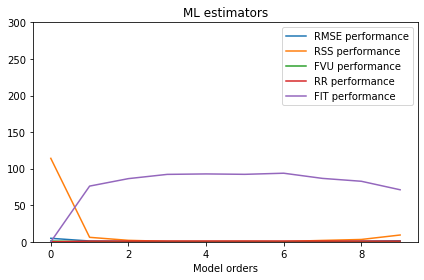

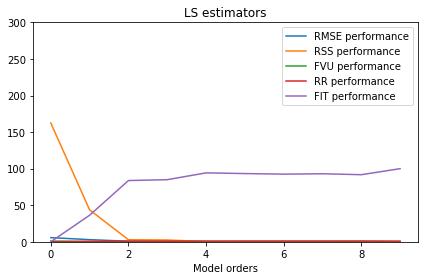

In [97]:

plotting(x_traning_set,y_traning_set)

Plotting the performance indexes as a function of the models orders on the test set

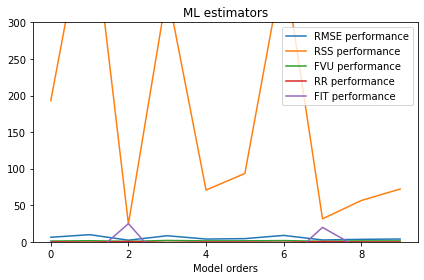

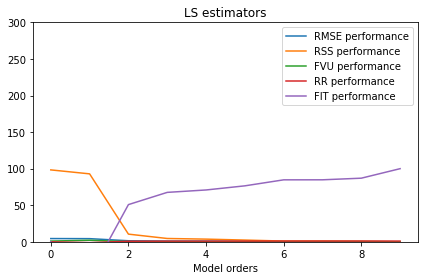

In [98]:
plotting(x_testing_set,y_testing_set)

Interpriting the data
For the traing set we can clearly see that as the model order increase, all the performance indexes reduce excpet for the FIT performance index. For the ML models, the FIT performance index increases til model order 1 and then stays more or less constant. For the LS models, the FIT performance index keeps increasing as the models orders also increase. This indicates that the higher level model orders are very good at a exactly modeling the data. To get an indication of whether this is overfitting the data, we have to take a look at how well the performance indexes performaned on the test set. 
For the test set the plots look quite different. For the ML models, the RMSE, RSS and the FIT performance index are quite terrible and not nearly as low as on the training set. This indicates that the ML models have been overfitted for the higher models orders. For the LS estimatros, it is hard to tell the plots apart because it seems like the all the performance idexes behaves the same way for both data set.  

I know that data that have been overfitted have lower bias because it makes a perfect model intersects all the points. Concequently when the model is used for a test set, it will not peform well because it is not generalized anymore and therefore it will also have high variance. 
On the other hand, data that are underfitted will have the opposite effect. It will have higher error on the trainig set because the model is too general, but it will also perform better on the test set as well. Therefore underfitted data will have higher bias but lower variance. 

We can see that for the lower order ML and LS models, the performance indexes performs more or less the same for both the training and test set. This could indicate that the data are underfitted. 